# Problem Statement

- At its core, churn prediction is a classification problem, where the classes often are ‘churned’ and ‘active’. The prediction is based on historical data, including customer behavior, demographics, transaction history, and more.

- Goal: well-balanced classification model.

- Since churn is not a positive outcome for a SaaS vendor, I will make the assumption that the focus of this classification model should be on maximizing recall (sensitivity metric) at the expense of the precision metric. 

- In doing so, most of the clients that will churn will be classified correctly (as true positives), while some that would not are also classified as potential churners (false positives). 

- This information can be used to offer some course of action, such as a new promotion to try and keep current SaaS clients from churning. 

- This is because the cost of churning is more expensive than the cost of sending a promotion to someone that would not churn (a false positive).

NOTE: Cell outputs should be viewed as scrollable elements for full coverage.

# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from scipy.stats import zscore, chi2_contingency

from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


sns.set(style='darkgrid')

# Data Loading and Summary Statistics

In [2]:
churn_df = pd.read_csv("/Desktop/cake/data/task_data_churned.csv")
churn_df.head()

ws_users_activated  ws_users_deactivated  ws_users_invited  \
0                   3                     2                 0   
1                   6                     1                 0   
2                   2                     0                 0   
3                   1                     0                 0   
4                   1                     0                 0   

   action_create_project  action_export_report  action_api_and_webhooks  \
0                      5                     8                        0   
1                     35                   106                        0   
2                      3                     3                        0   
3                      0                     0                        0   
4                      0                     0                        1   

   action_time_entries_via_tracker  action_start_trial  action_import_csv  \
0                                0                   0                  0   
1                               33                   0                  1   
2                                0                   0                  0   
3                                0                   0                  0   
4                                0                   0                  0   

   action_create_invoice  ...  action_screenshots  action_create_custom_field  \
0                      0  ...                 NaN                         NaN   
1                      0  ...                 NaN                         3.0   
2                      0  ...                 1.0                         NaN   
3                      0  ...                 1.0                         NaN   
4                      0  ...                 NaN                         NaN   

          country  value_days_to_purchase  value_number_of_active_months  \
0          Canada                       2                              0   
1  United Kingdom                      37                              9   
2         Florida                      98                              3   
3        Kentucky                       0                              1   
4         Ireland                      21                              2   

   value_transactions_number  value_regular_seats  value_kiosk_seats  revenue  \
0                          6                    3                  0  184.925   
1                          9                    6                  0  608.842   
2                         12                    3                  0  395.122   
3                          2                    1                  0   25.974   
4                          3                    1                  0   38.961   

   churned_status  
0              No  
1              No  
2              No  
3             Yes  
4             Yes  

[5 rows x 26 columns]

In [3]:
print("Dataset dimensions:", churn_df.shape)

Dataset dimensions: (2502, 26)


In [4]:
"""No negative numbers discovered, the ranges seem fine"""

print("\nSummary statistics:\n", churn_df.describe())


Summary statistics:
        ws_users_activated  ws_users_deactivated  ws_users_invited  \
count         2502.000000           2502.000000       2502.000000   
mean             5.619504              0.827738          0.158273   
std             11.364130              3.527056          0.784527   
min              0.000000              0.000000          0.000000   
25%              1.000000              0.000000          0.000000   
50%              2.000000              0.000000          0.000000   
75%              6.000000              0.000000          0.000000   
max            206.000000             73.000000         20.000000   

       action_create_project  action_export_report  action_api_and_webhooks  \
count            2502.000000           2502.000000              2502.000000   
mean               28.043965             22.709432                 0.383293   
std                80.761092             80.884964                 3.089846   
min                 0.000000            

In [5]:
print("\nSummary statistics:\n", churn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ws_users_activated               2502 non-null   int64  
 1   ws_users_deactivated             2502 non-null   int64  
 2   ws_users_invited                 2502 non-null   int64  
 3   action_create_project            2502 non-null   int64  
 4   action_export_report             2502 non-null   int64  
 5   action_api_and_webhooks          2502 non-null   int64  
 6   action_time_entries_via_tracker  2502 non-null   int64  
 7   action_start_trial               2502 non-null   int64  
 8   action_import_csv                2502 non-null   int64  
 9   action_create_invoice            2502 non-null   int64  
 10  action_lock_entries              2502 non-null   int64  
 11  action_add_targets               2502 non-null   int64  
 12  action_connect_quick

In [6]:
"""The class distribution is imbalanced, but the imbalance is not large, it might be necessary to use class weights to mitigate the imbalance"""

churn_df['churned_status'].value_counts()

churned_status
No     1703
Yes     799
Name: count, dtype: int64

## Split data into development and a post development set used for model scoring

In [7]:
seed = 23

test_size = 0.1

scoring_set = churn_df.sample(frac=test_size, random_state=seed)

development_set = churn_df.loc[~churn_df.index.isin(scoring_set.index)]

print("Training set shape:", development_set.shape)
print("Testing set shape:", scoring_set.shape)

print("Training set class distribution:", development_set['churned_status'].value_counts())
print("Testing set class distribution:", scoring_set['churned_status'].value_counts())


Training set shape: (2252, 26)
Testing set shape: (250, 26)
Training set class distribution: churned_status
No     1535
Yes     717
Name: count, dtype: int64
Testing set class distribution: churned_status
No     168
Yes     82
Name: count, dtype: int64


# Missing Values

- As could be seen from the prior summary statistics for the distributions of the features, there are outliers and missing values. Here the missing values are inspected.


Missing values:
 ws_users_activated                    0
ws_users_deactivated                  0
ws_users_invited                      0
action_create_project                 0
action_export_report                  0
action_api_and_webhooks               0
action_time_entries_via_tracker       0
action_start_trial                    0
action_import_csv                     0
action_create_invoice                 0
action_lock_entries                   0
action_add_targets                    0
action_connect_quickbooks             0
action_create_expense                 0
action_project_budget                 0
action_gps_tracking                1448
action_screenshots                 1307
action_create_custom_field         1850
country                              71
value_days_to_purchase                0
value_number_of_active_months         0
value_transactions_number             0
value_regular_seats                   0
value_kiosk_seats                     0
revenue               

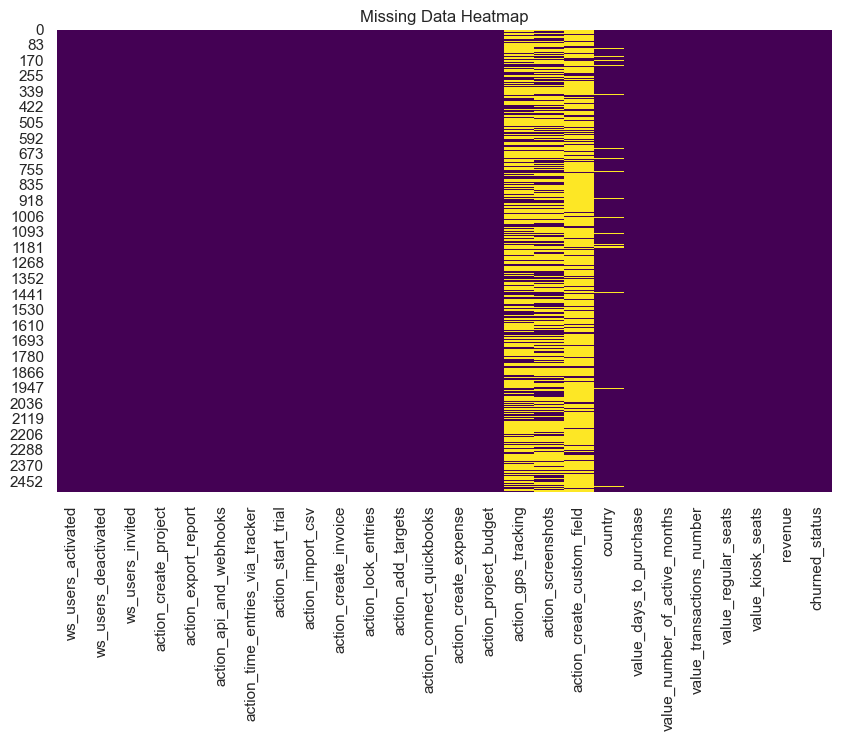

In [8]:
print("\nMissing values:\n", development_set.isnull().sum())

plt.figure(figsize=(10, 6))
sns.heatmap(development_set.isnull(), cmap='viridis', cbar=False)

# Customize the plot using Seaborn
plt.title('Missing Data Heatmap')
plt.show()

## Understanding Missing Data

- The columns that have the missing values relate to the actions the user can take on the SaaS, alongside the country that the user is from.

In [9]:
for col in ["action_gps_tracking","action_screenshots","action_create_custom_field","country"]:
    print(development_set[col].value_counts())

action_gps_tracking
1.0    578
2.0    179
3.0     29
4.0     13
5.0      2
6.0      2
8.0      1
Name: count, dtype: int64
action_screenshots
1.0     661
2.0     220
3.0      43
4.0      13
5.0       5
8.0       1
11.0      1
6.0       1
Name: count, dtype: int64
action_create_custom_field
2.0      103
1.0       60
4.0       39
3.0       33
6.0       32
5.0       25
8.0       16
7.0       15
10.0      14
9.0       10
13.0       7
12.0       6
20.0       5
18.0       3
11.0       3
21.0       3
14.0       3
17.0       3
16.0       2
19.0       2
35.0       2
57.0       2
24.0       2
106.0      1
53.0       1
32.0       1
42.0       1
81.0       1
54.0       1
56.0       1
65.0       1
25.0       1
28.0       1
61.0       1
52.0       1
Name: count, dtype: int64
country
California        228
Australia         143
Canada            131
Florida           110
United Kingdom    101
                 ... 
Seychelles          1
Iraq                1
Brunei              1
Sri Lanka           1


In [10]:
"""Here the target class imbalance of the data that lacks the values is noted. The imbalance seems to be representative when comparing the to overall imbalance."""

for col in ["action_gps_tracking","action_screenshots","action_create_custom_field","country"]:
    print(f"The column with the missing values is {col}, and the churned status looks like:")
    print(development_set[development_set[col].isnull()]['churned_status'].value_counts())

The column with the missing values is action_gps_tracking, and the churned status looks like:
churned_status
No     1021
Yes     427
Name: count, dtype: int64
The column with the missing values is action_screenshots, and the churned status looks like:
churned_status
No     916
Yes    391
Name: count, dtype: int64
The column with the missing values is action_create_custom_field, and the churned status looks like:
churned_status
No     1234
Yes     616
Name: count, dtype: int64
The column with the missing values is country, and the churned status looks like:
churned_status
No     58
Yes    13
Name: count, dtype: int64


In [11]:
"""The crosstabs below show that many of the missing values are present across multiple columns, indicating that entire rows are missing in most cases."""

cross_table = pd.crosstab(development_set['action_gps_tracking'].isnull(), development_set['action_screenshots'].isnull())
print("Cross-tabulation of missingness for action_gps_tracking and action_screenshots:\n", cross_table)

cross_table_2 = pd.crosstab(development_set['action_gps_tracking'].isnull(), development_set['action_create_custom_field'].isnull())
print("Cross-tabulation of missingness action_gps_tracking and action_create_custom_field:\n", cross_table_2)

cross_table_3 = pd.crosstab(development_set['action_screenshots'].isnull(), development_set['action_create_custom_field'].isnull())
print("Cross-tabulation of missingness action_screenshots and action_create_custom_field:\n", cross_table_3)


Cross-tabulation of missingness for action_gps_tracking and action_screenshots:
 action_screenshots   False  True 
action_gps_tracking              
False                  618    186
True                   327   1121
Cross-tabulation of missingness action_gps_tracking and action_create_custom_field:
 action_create_custom_field  False  True 
action_gps_tracking                     
False                         136    668
True                          266   1182
Cross-tabulation of missingness action_screenshots and action_create_custom_field:
 action_create_custom_field  False  True 
action_screenshots                      
False                         156    789
True                          246   1061


# Univariate Analysis

- The following step of the analysis is univariate analysis. Here the overarching theme is that the histograms show right skewed distributions, indicating the presence of outliers in the data.

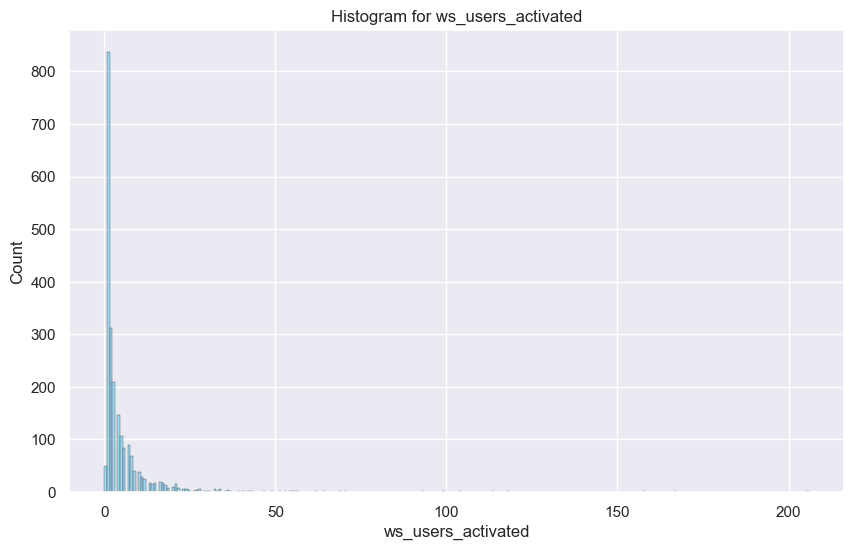

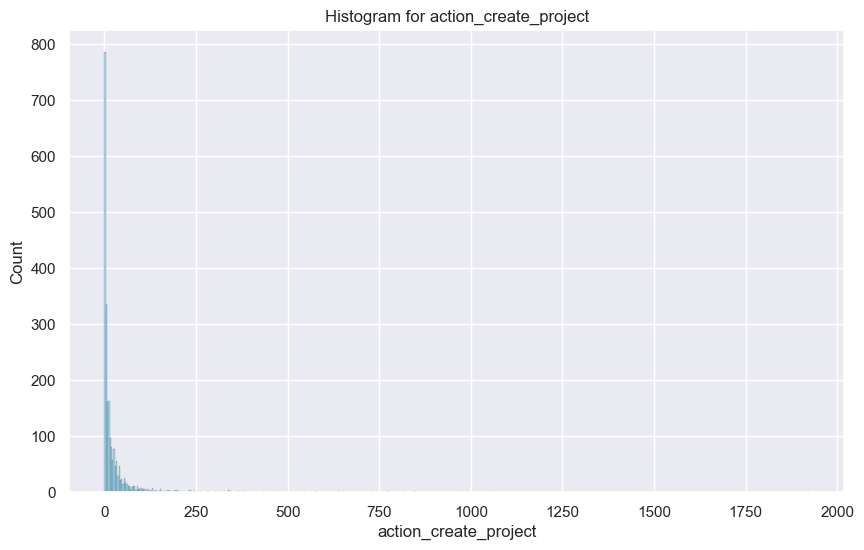

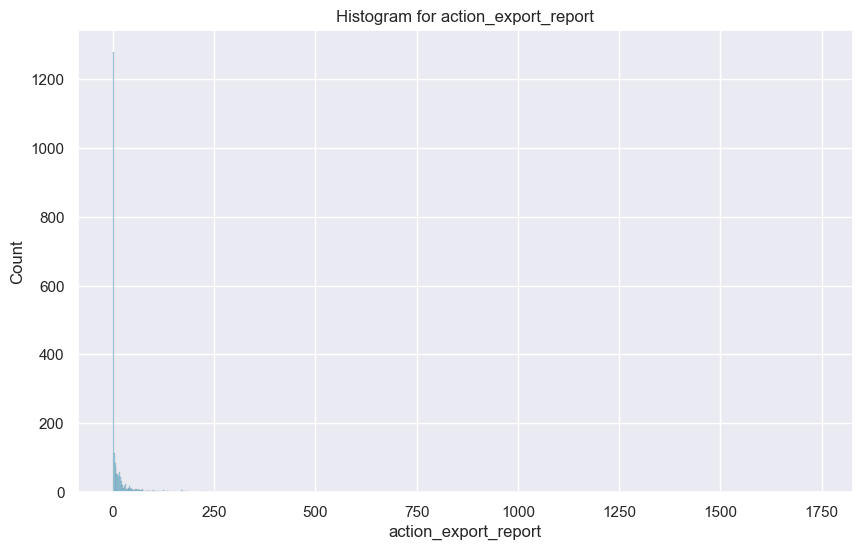

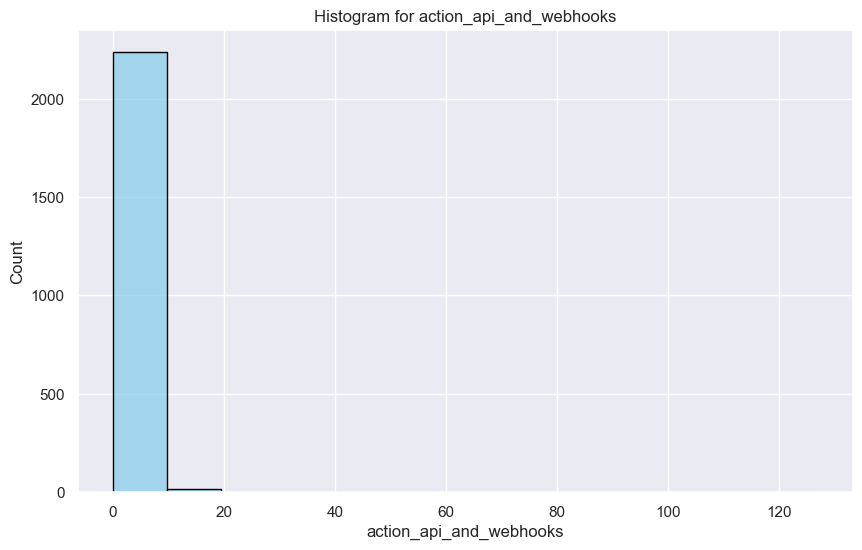

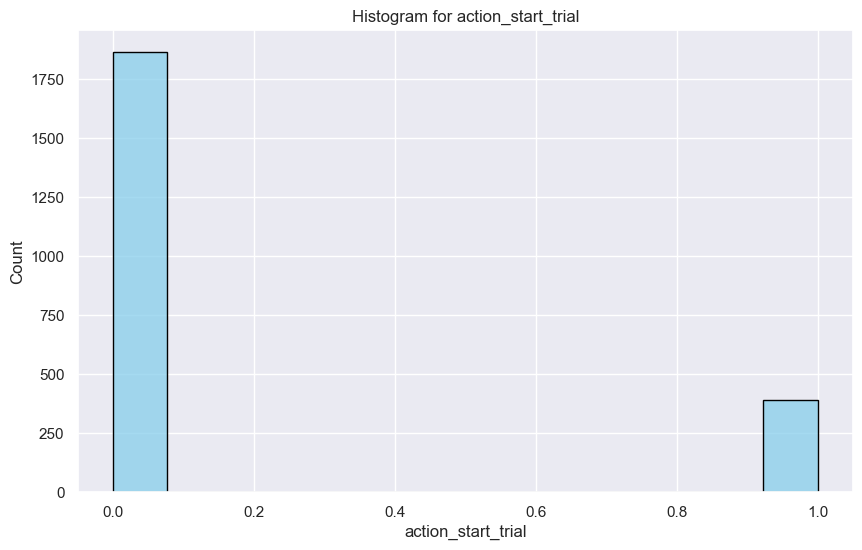

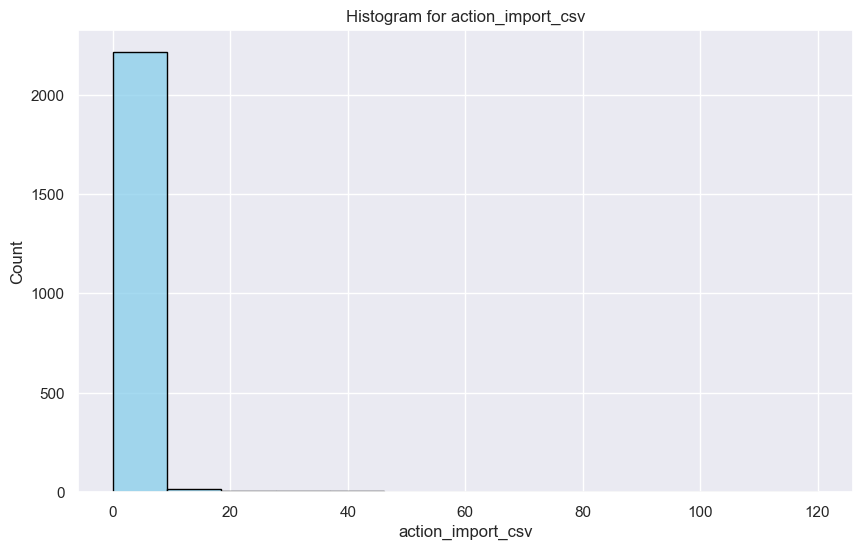

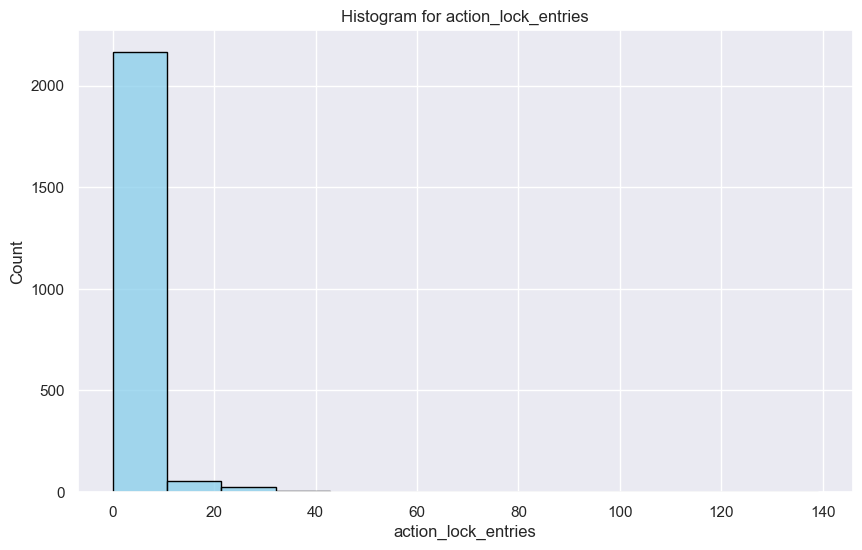

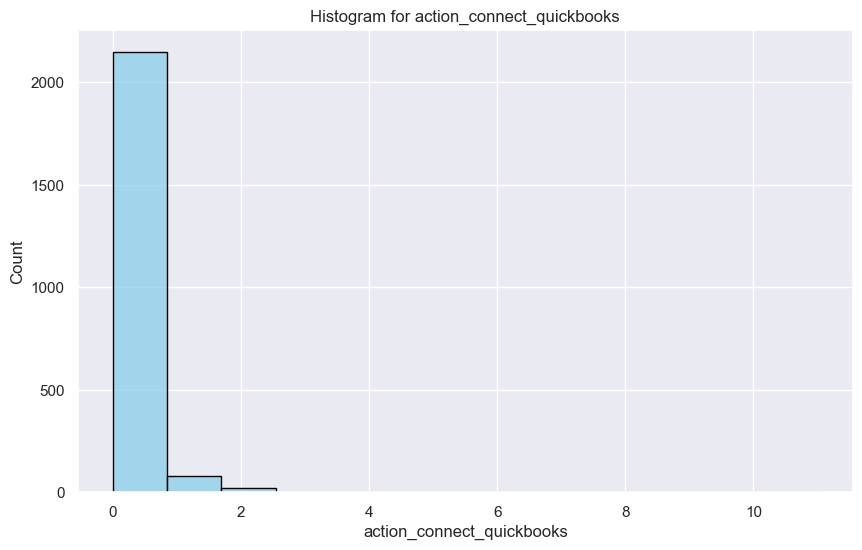

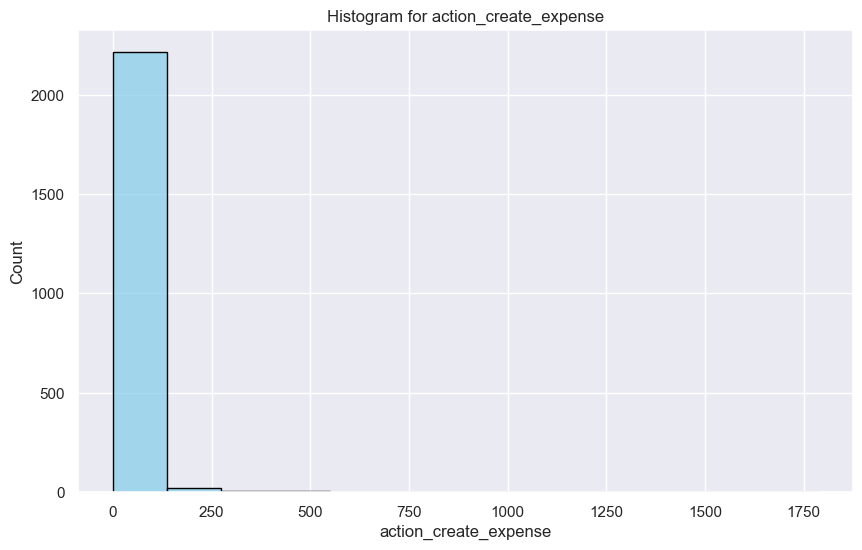

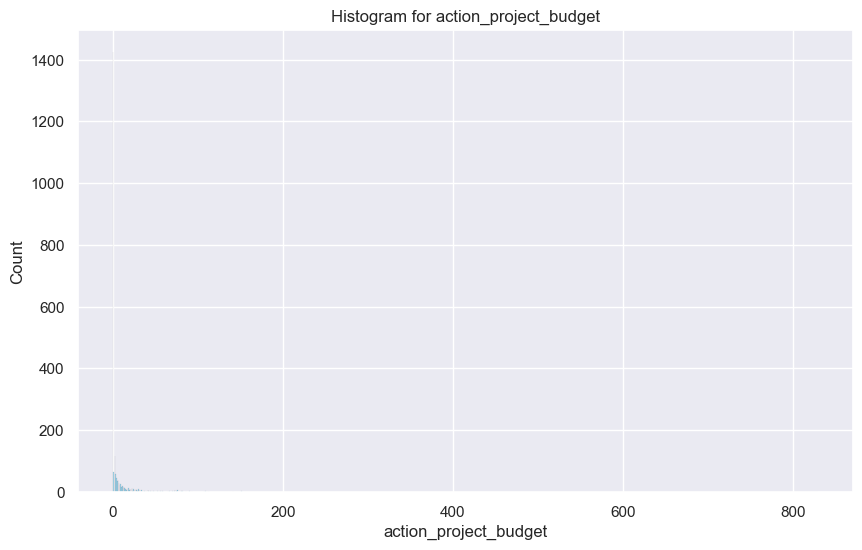

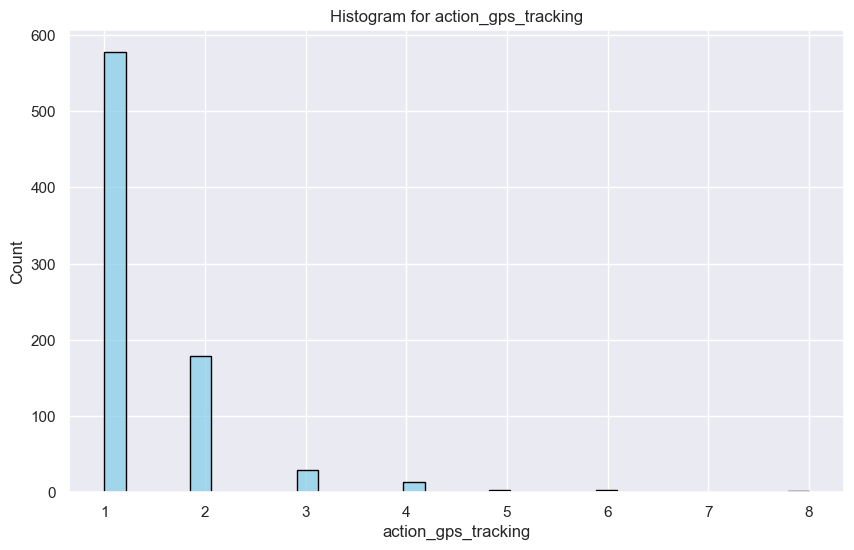

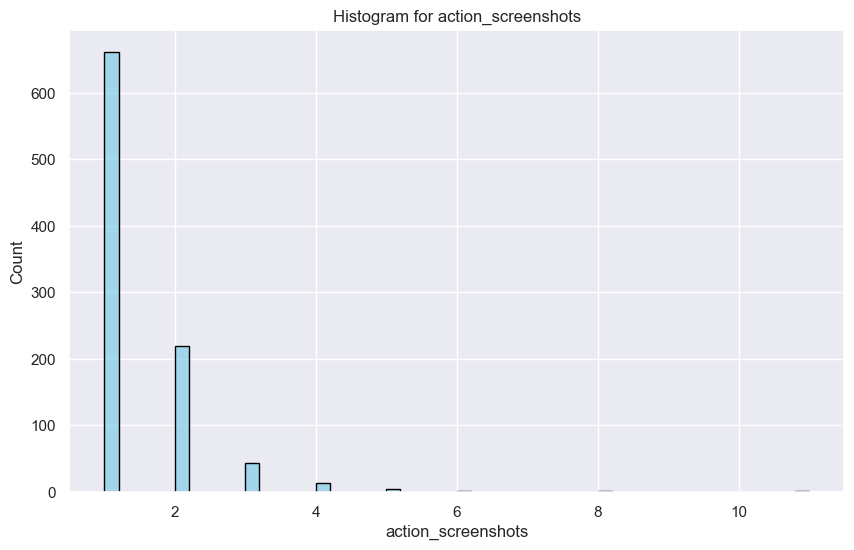

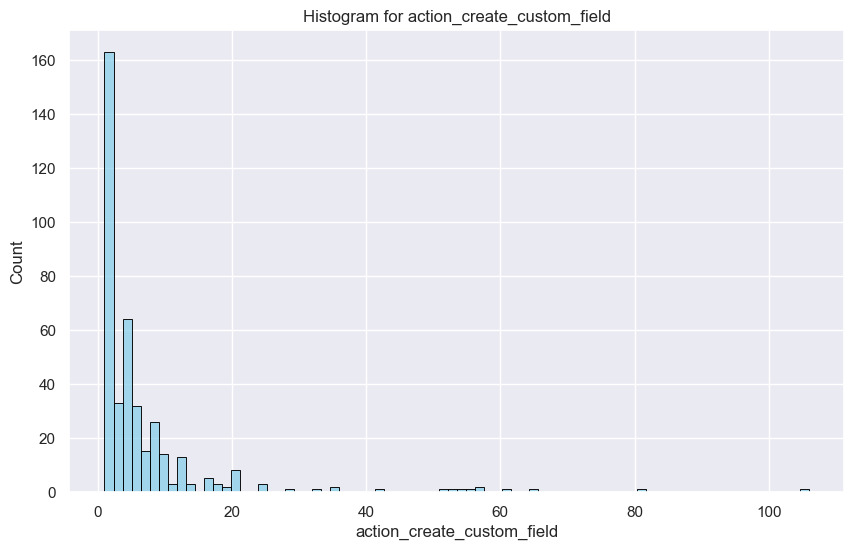

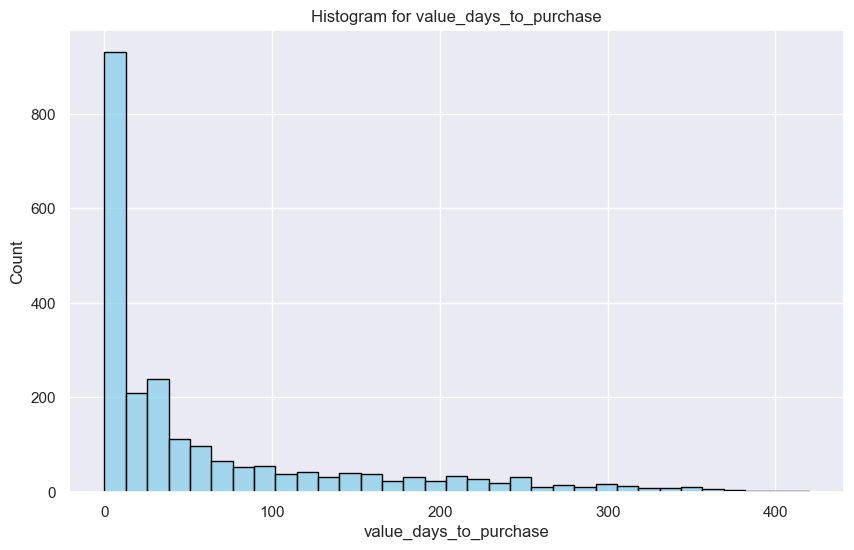

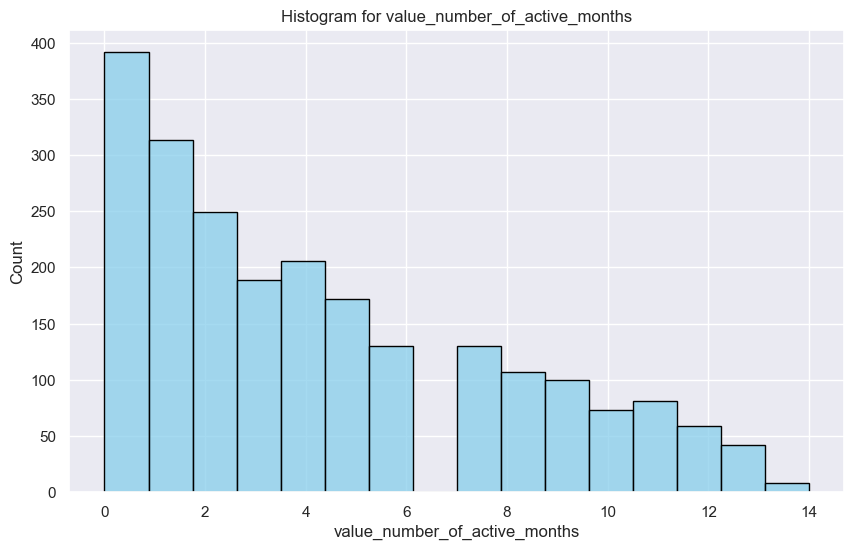

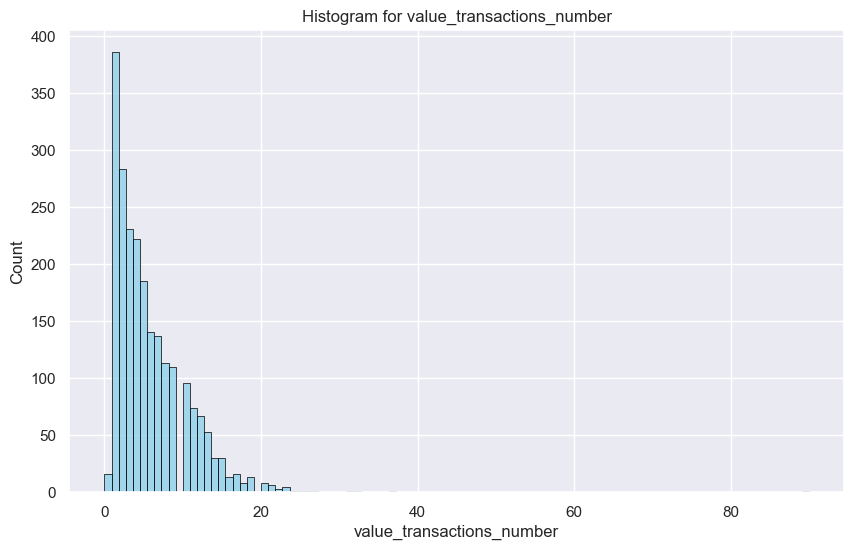

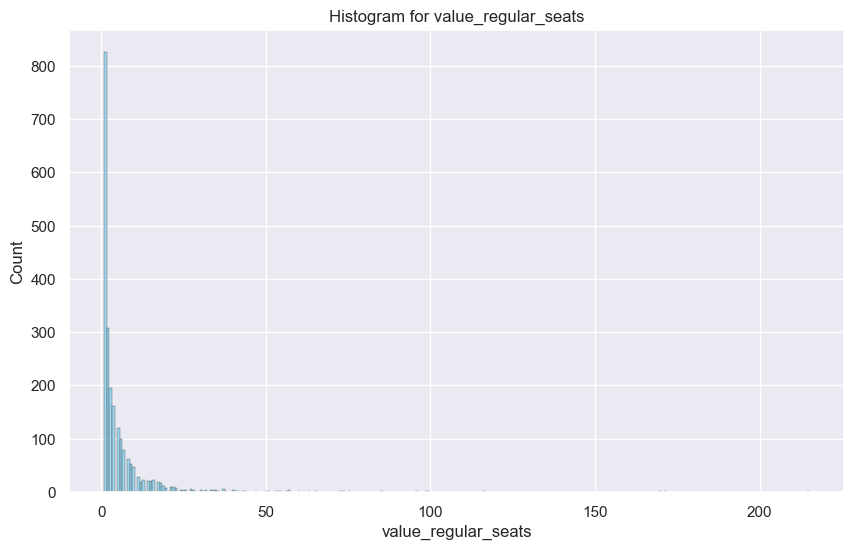

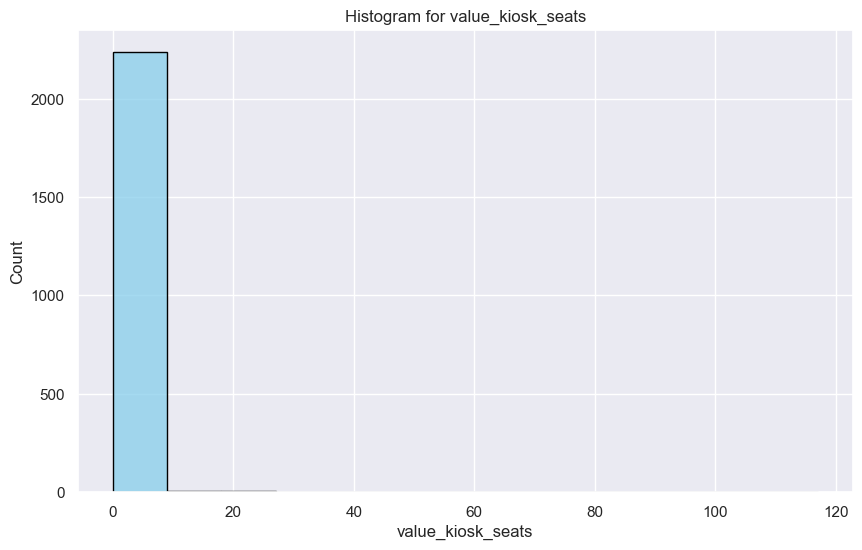

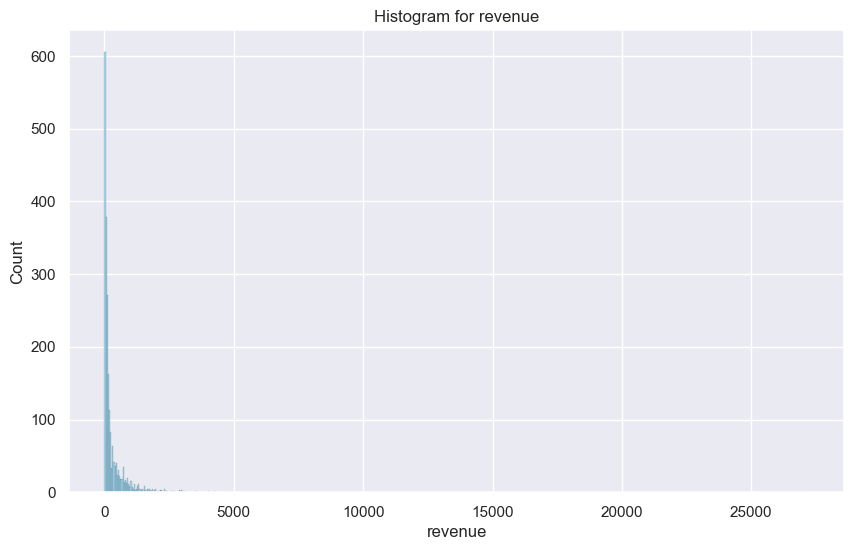

In [12]:
# Plot histograms for quantitative features
for col in development_set.select_dtypes(include=['float64', 'int64']).columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(development_set[col], kde=False, color='skyblue', edgecolor='black')
        plt.title(f'Histogram for {col}')
        plt.show()

/var/folders/bc/0k27_x817337qtf77c3140r40000gn/T/ipykernel_69846/940102594.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=filtered_df, order=filtered_df[col].value_counts().index, palette='viridis')


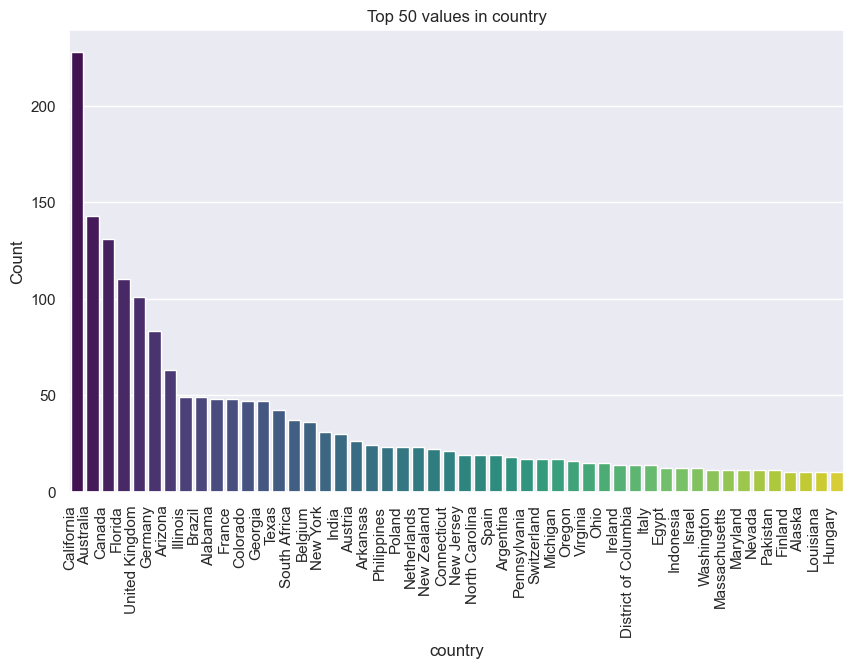

In [13]:
"""The only categorical feature present is 'country'. It is of high cardinality, over 150 distinct categories (151 in development set). Here The 50 largest categories are visualized."""

object_cols = development_set.select_dtypes(include='object')
selected_cols = object_cols.columns[object_cols.nunique() > 50]

for col in selected_cols:
    top_values = development_set[col].value_counts().nlargest(50).index

    filtered_df = development_set[development_set[col].isin(top_values)]

    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=filtered_df, order=filtered_df[col].value_counts().index, palette='viridis')
    plt.title(f'Top 50 values in {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90, ha='right')
    plt.show()

# Bivariate Analysis

- The pairplot shows interactions between multiple features alonside their distributions and for sake of classification visualizes the churned_status. There are some linear tendencies on a number of occasions, but nothing distict.

In [14]:
features = [feature for feature in development_set.select_dtypes(include=['float64', 'int64']).columns]
sns.pairplot(data=development_set,
             vars=features,
             hue='churned_status') 
plt.show()

# Correlation Analysis

- Since there are all but one feature that is quantitative, correlation analysis is used to determine if there is any multi-collinearity present in the dataset.

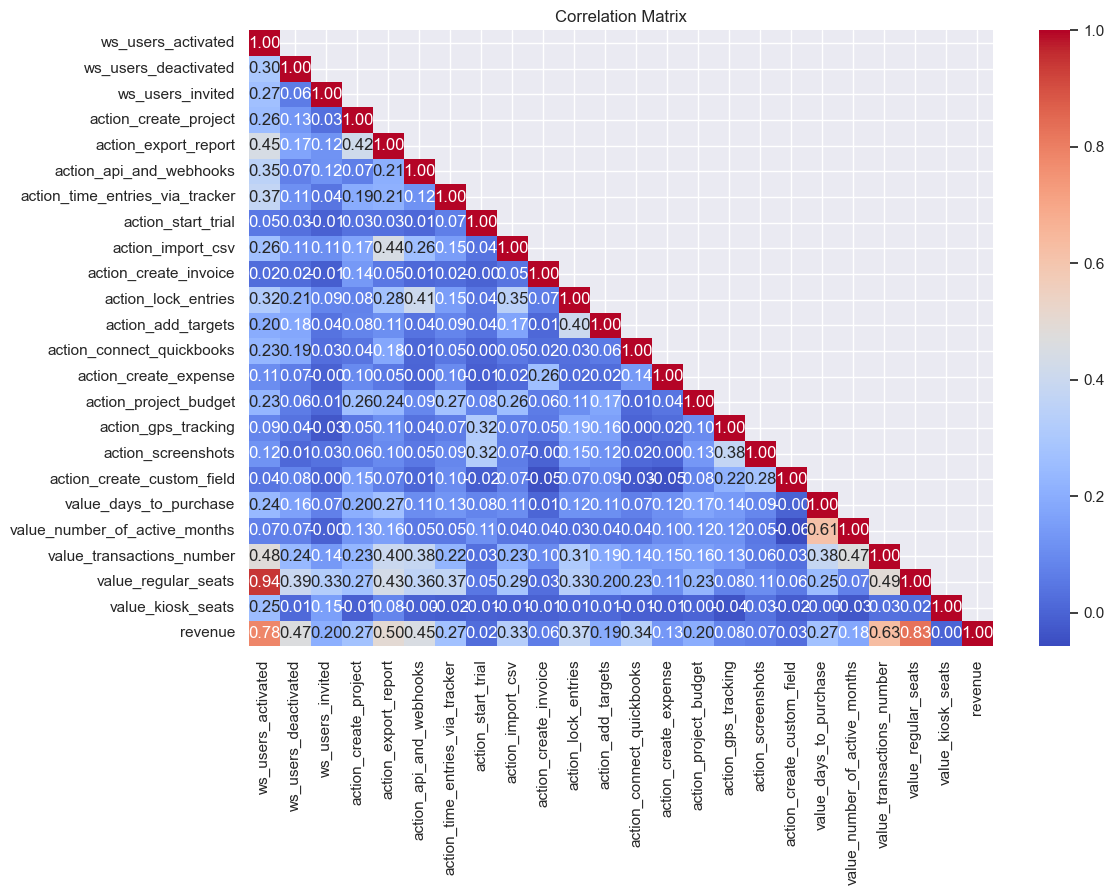

In [15]:
cols_to_use = [col for col in development_set.select_dtypes(include=['float64', 'int64']).columns]

correlation_matrix = development_set[cols_to_use].corr()

mask = np.triu(np.ones_like(correlation_matrix), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title('Correlation Matrix')
plt.show()

In [16]:
"""Looking into multi-collinearity for possible removal of features. As can be seen by the print statement below there are mutliple features that can be excluded to remove multi-collinearity."""

# Identify highly correlated features
highly_correlated = (correlation_matrix.abs() > 0.7) & (correlation_matrix.abs() < 1.0)

# Display pairs of highly correlated features
print("Pairs of highly correlated features:\n", correlation_matrix[highly_correlated].stack())


Pairs of highly correlated features:
 ws_users_activated   value_regular_seats    0.942796
                     revenue                0.783867
value_regular_seats  ws_users_activated     0.942796
                     revenue                0.827525
revenue              ws_users_activated     0.783867
                     value_regular_seats    0.827525
dtype: float64


# Dealing with missing values

- Missing values seem that are relating to action features such as the ones below, all contain counts greater than 0, hence I am inferring that fields that have NaNs are actually fields that have not been instantiated yet, so in order to fix the missing values issue, I will impute the NaNs with 0's.
- For the 'country' feature, it is categorical and in nature high cardinal with over 150 distinct country names. In order to do imputation using a neural network or a unsupervised machine learning algorithm, this would be a daunting task. So I have decided to drop the values that are missing, as there aren't many of them.

In [17]:
churn_df_imputed = development_set.copy()
for col in ["action_gps_tracking","action_screenshots","action_create_custom_field"]:
    churn_df_imputed[col].fillna(0, inplace=True)

print("\nMissing values:\n", churn_df_imputed.isnull().sum())


Missing values:
 ws_users_activated                  0
ws_users_deactivated                0
ws_users_invited                    0
action_create_project               0
action_export_report                0
action_api_and_webhooks             0
action_time_entries_via_tracker     0
action_start_trial                  0
action_import_csv                   0
action_create_invoice               0
action_lock_entries                 0
action_add_targets                  0
action_connect_quickbooks           0
action_create_expense               0
action_project_budget               0
action_gps_tracking                 0
action_screenshots                  0
action_create_custom_field          0
country                            71
value_days_to_purchase              0
value_number_of_active_months       0
value_transactions_number           0
value_regular_seats                 0
value_kiosk_seats                   0
revenue                             0
churned_status                  

In [18]:
churn_df_imputed['country'].isnull().sum()

71

In [19]:
churn_df_imputed.dropna(subset=['country'], inplace=True)
print(churn_df_imputed['country'].isnull().sum())
print(churn_df_imputed.shape)

0
(2181, 26)


Again, since there are 150 categories for 'country' I cannot use one-hot encoding as it will polute the feature space with too many dimensions. Instead, I have opted into using target mean encoding to encode the categorical feature, as seen below.

In [20]:
churn_df_imputed['churned_status_int'] = churn_df_imputed['churned_status'].apply(lambda x: 1 if x == 'Yes' else 0)

target_mean_encoding = churn_df_imputed.groupby('country')['churned_status_int'].mean()

churn_df_imputed['country_encoded'] = churn_df_imputed['country'].map(target_mean_encoding)


In [21]:
"""I am serializing the pandas series with 'country' and the corresponding encoding value in order to use it for inference when classifying the unseen dataset."""

joblib.dump(target_mean_encoding, "country_mean_encoding.joblib")


['country_mean_encoding.joblib']

In [22]:
"""A quick glance at the head of the current dataframe"""

churn_df_imputed.head()

ws_users_activated  ws_users_deactivated  ws_users_invited  \
0                   3                     2                 0   
1                   6                     1                 0   
3                   1                     0                 0   
4                   1                     0                 0   
5                   1                     0                 0   

   action_create_project  action_export_report  action_api_and_webhooks  \
0                      5                     8                        0   
1                     35                   106                        0   
3                      0                     0                        0   
4                      0                     0                        1   
5                      0                     1                        0   

   action_time_entries_via_tracker  action_start_trial  action_import_csv  \
0                                0                   0                  0   
1                               33                   0                  1   
3                                0                   0                  0   
4                                0                   0                  0   
5                                0                   0                  0   

   action_create_invoice  ...         country  value_days_to_purchase  \
0                      0  ...          Canada                       2   
1                      0  ...  United Kingdom                      37   
3                      0  ...        Kentucky                       0   
4                      0  ...         Ireland                      21   
5                      1  ...     Philippines                      32   

   value_number_of_active_months  value_transactions_number  \
0                              0                          6   
1                              9                          9   
3                              1                          2   
4                              2                          3   
5                             14                         14   

   value_regular_seats  value_kiosk_seats  revenue  churned_status  \
0                    3                  0  184.925              No   
1                    6                  0  608.842              No   
3                    1                  0   25.974             Yes   
4                    1                  0   38.961             Yes   
5                    1                  0  168.116              No   

  churned_status_int  country_encoded  
0                  0         0.358779  
1                  0         0.326733  
3                  1         0.625000  
4                  1         0.214286  
5                  0         0.521739  

[5 rows x 28 columns]

In [23]:
"""Exporting the dataset to run AutoML in the cloud"""

# churn_df_imputed.to_csv('development_set.csv', index=False)

'Exporting the dataset to run AutoML in the cloud'

# Outliers

- As mentioned earlier the dataset is plagued with outliers. I believe that they should not be removed immediately, but instead understood for sake of analysis.
- I am using three standard deviations from the mean as my threshold for classifying outliers across the multiple features in the dataset.

In [24]:
threshold = 3

for col in churn_df_imputed.select_dtypes(include=['float64', 'int64']).columns:
    z_scores = zscore(churn_df_imputed[col])
    mean_val = np.mean(churn_df_imputed[col])
    std_val = np.std(churn_df_imputed[col])
    # Identify outliers
    outliers = churn_df_imputed[col][abs(z_scores) > threshold]
    if not outliers.empty:
        print(f"These are the outliers for the feature: {col}. The mean for this feature is {mean_val}, while the standard dev is {std_val}")
        print(outliers)

These are the outliers for the feature: ws_users_activated. The mean for this feature is 5.119669876203576, while the standard dev is 9.273513830425598
146      99
171      36
216     158
272      57
296      54
424      41
465      49
522      43
531      35
550      70
594      42
616      37
668      34
676      34
697      39
721      33
830      51
899     114
976      41
995      37
1076     51
1232     36
1316     69
1422     55
1429     47
1463     43
1527     62
1540     34
1662     56
1778     93
1824    118
1908     34
1964     53
2053     99
2122     36
2187     57
2211     34
2416     62
Name: ws_users_activated, dtype: int64
These are the outliers for the feature: ws_users_deactivated. The mean for this feature is 0.7281063732232921, while the standard dev is 3.2971280264771186
95      14
240     11
246     29
297     12
413     41
434     73
487     14
550     16
633     19
668     26
715     27
717     11
728     15
761     61
866     34
899     17
925     13
995     16

In [25]:
"""The outliers all seem to be reasonable for the sake and nothing seems to be out of the ordinary. For certain features, if a user is active, more actions are to take place
as well as more revenue, etc..."""

'The outliers all seem to be reasonable for the sake and nothing seems to be out of the ordinary. For certain features, if a user is active, more actions are to take place\nas well as more revenue, etc...'

# Correlation Analysis on ready dataset

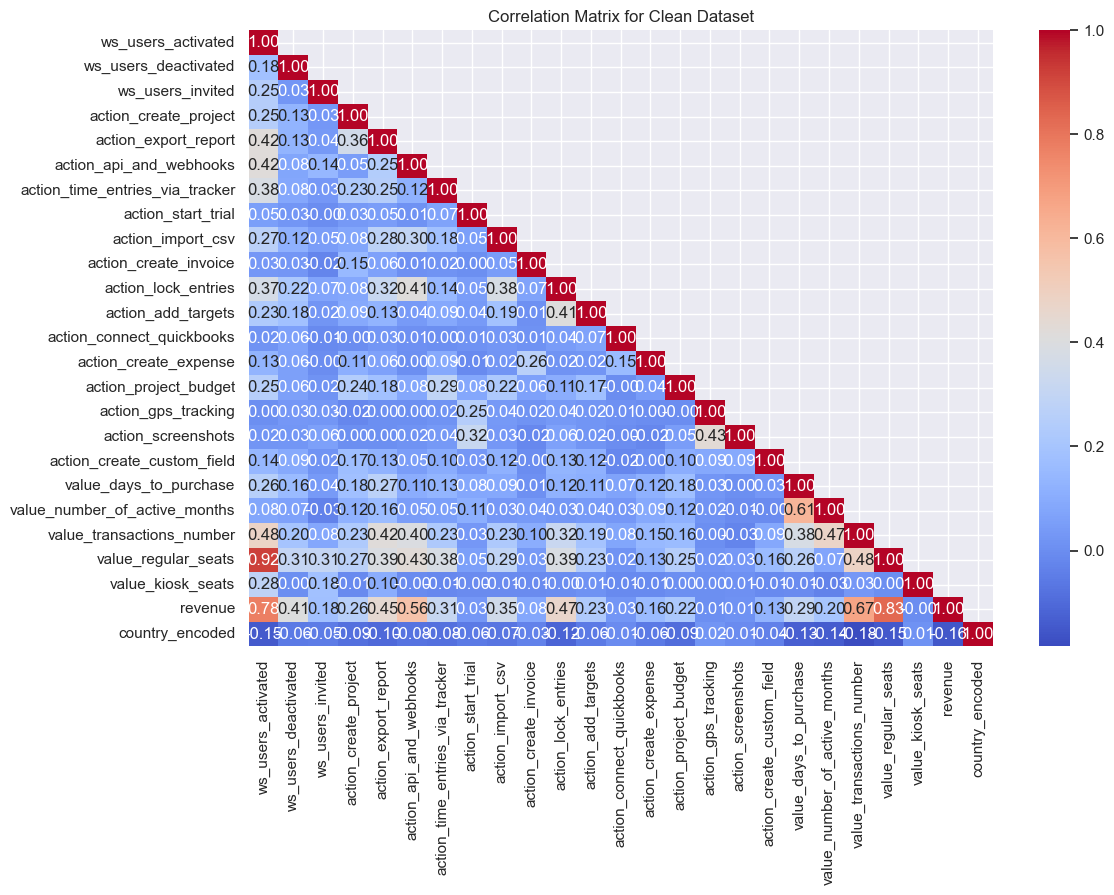

In [26]:
cols_to_use = [col for col in churn_df_imputed.select_dtypes(include=['float64', 'int64']).columns if col != 'churned_status_int']

correlation_matrix = churn_df_imputed[cols_to_use].corr()

mask = np.triu(np.ones_like(correlation_matrix), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", mask=mask)
plt.title('Correlation Matrix for Clean Dataset')
plt.show()

# Mututal Information Gain Between each quantitative feature and the binary target

In [27]:
"""Mutual information is a measure of dependence between variables and can be used for feature selection when doing binary classification.
It is a unitless quantity that reflects the amount of information shared between a feature and the target variable in a classification problem.
The mutual information values are normalized in a way that higher values indicate a stronger relationship between the feature and the target variable. 
The actual range of the mutual information values depends on the characteristics of the data."""

cols_to_use = [col for col in churn_df_imputed.select_dtypes(include=['float64', 'int64']).columns if col != 'churned_status_int']

# Select quantitative features and binary target
quantitative_features = churn_df_imputed[cols_to_use]
binary_target = churn_df_imputed['churned_status'].apply(lambda x: 1 if x == 'Yes' else 0)

# Calculate mutual information between features and target
mutual_info_scores = mutual_info_classif(quantitative_features, binary_target)

correlation_df = pd.DataFrame({'Feature': quantitative_features.columns, 'Mutual_Info_Score': mutual_info_scores})
correlation_df = correlation_df.sort_values(by='Mutual_Info_Score', ascending=False)

print(correlation_df)

                            Feature  Mutual_Info_Score
19    value_number_of_active_months           0.072450
23                          revenue           0.050433
0                ws_users_activated           0.047902
6   action_time_entries_via_tracker           0.047020
20        value_transactions_number           0.046880
21              value_regular_seats           0.045341
24                  country_encoded           0.023029
12        action_connect_quickbooks           0.022373
5           action_api_and_webhooks           0.022212
4              action_export_report           0.018952
14            action_project_budget           0.017968
15              action_gps_tracking           0.013381
3             action_create_project           0.013157
13            action_create_expense           0.012598
1              ws_users_deactivated           0.012020
18           value_days_to_purchase           0.011605
2                  ws_users_invited           0.011343
8         

Based on mutual info score it can be deduced that ws_users_activate, revenue, and value_number_of_active_months are the most valuable features. This makes sense as the two indicate the number of users activated and active usage and the period of time. Even without considering a SaaS setting as this one, this makes sense, user activity and duration of use can directly influence them leaving some product.

# Feature Engineering and Selection

- For the sake of time I will run a chi squared test to check the independence between the only categorical feature and the target feature.
- I will not be doing any wrapper methods (forward/backward elimination, recursive feature elimination, or sequential feature selection) to save time.
- I will be relying on embedded methods such as Lasso/Ridge Regularization in case of linear model or GBM in case of non-linear models.

In [28]:
contingency_table = pd.crosstab(churn_df_imputed['country'], churn_df_imputed['churned_status_int'])

chi2, p, _, _ = chi2_contingency(contingency_table)

if p < 0.05:
    print("The two variables are dependent.")
else:
    print("The two variables are independent.")


The two variables are independent.


Interestingly country and churned_status_int are independent.

# Linearity Checks

- To see whether the data can be modelled linearly some assumptions need to be made:
1. Linearity: The relationship between the features and the log-odds of the response variable (in the case of logistic regression) is assumed to be linear. This implies that the decision boundary separating the two classes is a linear function of the input features
2. The response variable is binary
3. Independence of observations (samples)
4. There is no multicollinearity among explanatory variables (VIF values)
5. No extreme outliers
6. Correct Specification of the model in terms of features selected

- In order to mitigate the outliers that can all be accounted for, the following transformations will need to take place to reduce the range of the inputs.
- A log1p will be used followed by standardization (z-score normalization).


In [29]:
cols_to_use = [col for col in churn_df_imputed.select_dtypes(include=['float64', 'int64']).columns if col != 'churned_status_int']

X = churn_df_imputed[cols_to_use]
y = churn_df_imputed["churned_status_int"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply log1p transformation to features
X_train_log1p = np.log1p(X_train)
X_test_log1p = np.log1p(X_test)

# Standardize the data
scaler = StandardScaler()
X_train_log1p_scaled = scaler.fit_transform(X_train_log1p)
X_test_log1p_scaled = scaler.transform(X_test_log1p)

# Train logistic regression model
model = LogisticRegression(penalty='l2')
model.fit(X_train_log1p_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_log1p_scaled)

# Check for multicollinearity (VIF)
vif_data = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
print("VIF:")
print(vif)

# Additional diagnostics to check for linearity

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

VIF:
                           Variable        VIF
0                             const  11.856795
1                ws_users_activated  18.405955
2              ws_users_deactivated   1.633215
3                  ws_users_invited   1.367216
4             action_create_project   1.290054
5              action_export_report   1.533273
6           action_api_and_webhooks   1.743600
7   action_time_entries_via_tracker   1.291364
8                action_start_trial   1.162937
9                 action_import_csv   1.305792
10            action_create_invoice   1.117357
11              action_lock_entries   1.713294
12               action_add_targets   1.314692
13        action_connect_quickbooks   1.044698
14            action_create_expense   1.151649
15            action_project_budget   1.223538
16              action_gps_tracking   1.262912
17               action_screenshots   1.323405
18       action_create_custom_field   1.078622
19           value_days_to_purchase   1.820064
20    va

Below I define two helper functions, the first for plotting the confusion matrix and the other for calculating Youden's J Statistic.

In [30]:
def plot_cm(labels, predictions, p=0.5) -> sns.heatmap:
    """Returns a confusion matrix as a seaborn heatmap"""
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix @{:.4f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('-'*20)
    print('The threshold is {}'.format(p))
    print('TN', cm[0][0])
    print('FP', cm[0][1])
    print('FN', cm[1][0])
    print('TP', cm[1][1])
    print('TOTAL CHURNS', np.sum(cm[1]))
    print('-'*20)

In [31]:
def youdins_j(y_train, yhat) -> float:
    """Returns the optimal threshold for Youdin's J Statistic"""
    fpr, tpr, thresholds = metrics.roc_curve(y_train, yhat)

    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % best_thresh)
    return best_thresh

--------------------
The threshold is 0.5
TN 262
FP 44
FN 55
TP 76
TOTAL CHURNS 131
--------------------


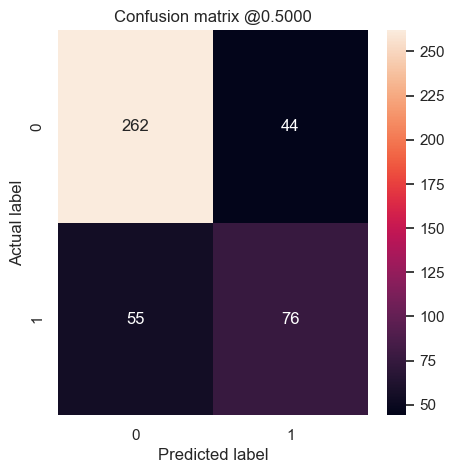

In [32]:
plot_cm(y_test, y_pred)

In [33]:
yhat = model.predict_proba(X_train)[:,1]

best_thresh = youdins_j(y_train, yhat)

Best Threshold=0.918110


/Users/savastakic/opt/anaconda3/envs/savaML_env/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


using Youdin's J I get the optimal threshold for our problem statement, this is the threshold used for threshold tuning for optimal scoring.

--------------------
The threshold is 0.5
TN 15
FP 291
FN 0
TP 131
TOTAL CHURNS 131
--------------------


/Users/savastakic/opt/anaconda3/envs/savaML_env/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


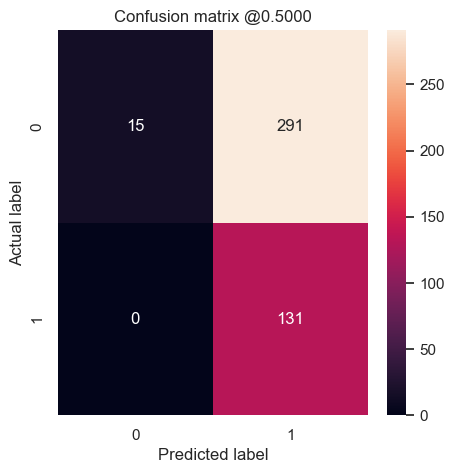

In [34]:
plot_cm(y_test, model.predict_proba(X_test)[:,1],p=0.5)

/Users/savastakic/opt/anaconda3/envs/savaML_env/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


--------------------
The threshold is 0.9181096803369113
TN 18
FP 288
FN 1
TP 130
TOTAL CHURNS 131
--------------------


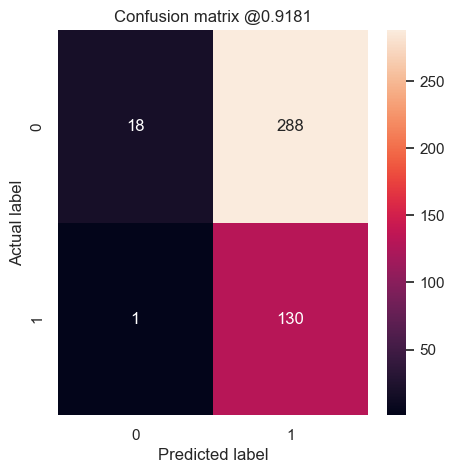

In [35]:
plot_cm(y_test, model.predict_proba(X_test)[:,1],p=best_thresh)

# Modelling

In order to speed up the modelling process I went ahead and passed the entire dataframe into H2O AutoML to get the best performing model. The winner was a GBM classifier. Next I do a grid search to get the optimal hyperparameters.

In [36]:
pipe = Pipeline([('classifier', GradientBoostingClassifier())])


grid_param = [
                {'classifier': [GradientBoostingClassifier()],
#                  'classifier__loss': ['deviance', 'exponential'],
                 'classifier__learning_rate': [0.1],
                 'classifier__n_estimators':[26, 24, 25, 40],
                 'classifier__subsample': [0.8],
#                  'classifier__min_samples_split': [],
                 'classifier__min_samples_leaf': [10, 20, 30],
                 'classifier__max_depth':[8, 17, 20],
#                  'classifier__min_impurity_decrease': [],
#                  'classifier__min_impurity_split': [],
                 'classifier__random_state': [23],
#                  'classifier__max_features':['auto', 'sqrt', 'log2'],
#                  'classifier__max_leaf_nodes':[],
#                  'classifier__ccp_alpha':[]
                }
    
]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=1, n_jobs=-1, scoring="roc_auc")
best_model = gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [37]:
print(best_model.best_estimator_)
print('-'*20)
print(best_model.best_params_)
print('-'*20)
print(best_model.cv_results_)

Pipeline(steps=[('classifier',
                 GradientBoostingClassifier(max_depth=8, min_samples_leaf=20,
                                            n_estimators=26, random_state=23,
                                            subsample=0.8))])
--------------------
{'classifier': GradientBoostingClassifier(max_depth=8, min_samples_leaf=20, n_estimators=26,
                           random_state=23, subsample=0.8), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__min_samples_leaf': 20, 'classifier__n_estimators': 26, 'classifier__random_state': 23, 'classifier__subsample': 0.8}
--------------------
{'mean_fit_time': array([0.1523674 , 0.15552797, 0.15513649, 0.2480453 , 0.13922472,
       0.13918791, 0.12425761, 0.2135385 , 0.11890879, 0.12155356,
       0.11971602, 0.19607038, 0.23981276, 0.19449415, 0.21644139,
       0.34174719, 0.15994625, 0.14588356, 0.15459285, 0.25540762,
       0.13676119, 0.14413629, 0.12503729, 0.22019615, 0.20622458,
       0.20

The optimal threshold using threshold tuning is calculated next.

In [38]:
yhat = best_model.predict_proba(X_train)[:,1]

best_thresh = youdins_j(y_train, yhat)

Best Threshold=0.362601


--------------------
The threshold is 0.5
TN 274
FP 32
FN 57
TP 74
TOTAL CHURNS 131
--------------------


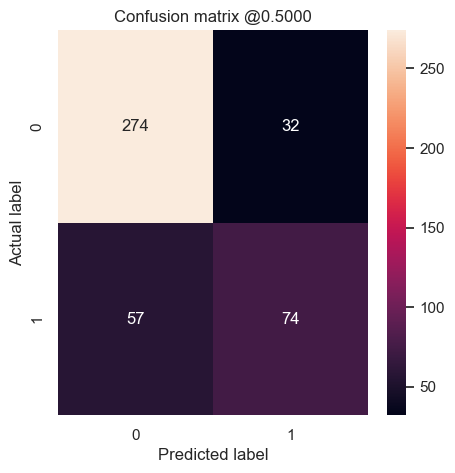

In [39]:
# Compare default threshold to optimal threshold based on Youden's J

plot_cm(y_test, best_model.predict_proba(X_test)[:,1],p=0.5)


--------------------
The threshold is 0.36260121360072306
TN 237
FP 69
FN 37
TP 94
TOTAL CHURNS 131
--------------------


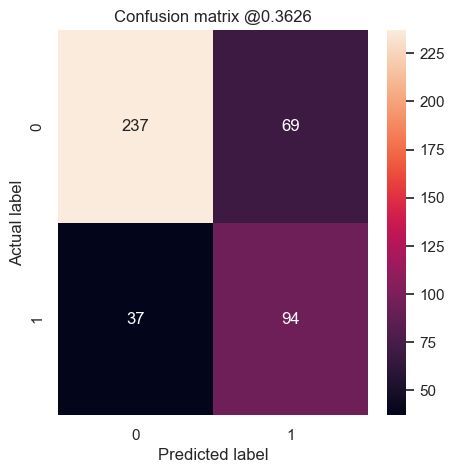

In [40]:
plot_cm(y_test, best_model.predict_proba(X_test)[:,1],p=best_thresh)

In [41]:
feature_importance = pd.Series(data= best_model.best_estimator_.named_steps['classifier'].feature_importances_, 
                               index = np.array(cols_to_use))


feature_importance.sort_values(ascending=False)[:20]


value_number_of_active_months      0.234387
country_encoded                    0.134555
ws_users_activated                 0.102234
value_days_to_purchase             0.096782
revenue                            0.089485
action_time_entries_via_tracker    0.081324
value_transactions_number          0.078516
action_create_project              0.046586
action_export_report               0.030021
action_project_budget              0.020106
action_create_invoice              0.018123
value_regular_seats                0.016807
action_screenshots                 0.011769
ws_users_deactivated               0.009947
action_gps_tracking                0.009053
action_lock_entries                0.005341
action_add_targets                 0.003762
action_create_expense              0.003508
action_create_custom_field         0.002684
action_api_and_webhooks            0.002142
dtype: float64

Interestingly the GBM classifier found 'value_number_of_active_months' and 'ws_users_activated', similar to when the information gain analysis was done earlier. In addition it notes 'country_encoded' as an important feature.

# Scoring on unseen data

- scoring_set is the unseen dataset for scoring

In [42]:
"""First the necessary preprocessing is done in order to get the data ready for predicting"""

for col in ["action_gps_tracking","action_screenshots","action_create_custom_field"]:
    scoring_set[col].fillna(0, inplace=True)

print("\nMissing values:\n", scoring_set.isnull().sum())


Missing values:
 ws_users_activated                  0
ws_users_deactivated                0
ws_users_invited                    0
action_create_project               0
action_export_report                0
action_api_and_webhooks             0
action_time_entries_via_tracker     0
action_start_trial                  0
action_import_csv                   0
action_create_invoice               0
action_lock_entries                 0
action_add_targets                  0
action_connect_quickbooks           0
action_create_expense               0
action_project_budget               0
action_gps_tracking                 0
action_screenshots                  0
action_create_custom_field          0
country                            13
value_days_to_purchase              0
value_number_of_active_months       0
value_transactions_number           0
value_regular_seats                 0
value_kiosk_seats                   0
revenue                             0
churned_status                  

In [43]:
"""The encoding pandas series is deserialized and loaded again."""
loaded_country_mean_encoding = joblib.load('country_mean_encoding.joblib')

scoring_set['churned_status_int'] = scoring_set['churned_status'].apply(lambda x: 1 if x == 'Yes' else 0)

target_mean_encoding = loaded_country_mean_encoding

scoring_set['country_encoded'] = scoring_set['country'].map(target_mean_encoding)

In [44]:
"""Countries that do not have an encoding are assigned a value of 1, indicating that they are most likely treated as outliers and group with other countries that aren't frequent."""

scoring_set['country_encoded'].fillna(1, inplace=True)

In [45]:
scoring_set.isnull().sum()

ws_users_activated                  0
ws_users_deactivated                0
ws_users_invited                    0
action_create_project               0
action_export_report                0
action_api_and_webhooks             0
action_time_entries_via_tracker     0
action_start_trial                  0
action_import_csv                   0
action_create_invoice               0
action_lock_entries                 0
action_add_targets                  0
action_connect_quickbooks           0
action_create_expense               0
action_project_budget               0
action_gps_tracking                 0
action_screenshots                  0
action_create_custom_field          0
country                            13
value_days_to_purchase              0
value_number_of_active_months       0
value_transactions_number           0
value_regular_seats                 0
value_kiosk_seats                   0
revenue                             0
churned_status                      0
churned_stat

In [46]:
cols_to_use = [col for col in scoring_set.select_dtypes(include=['float64', 'int64']).columns if col != 'churned_status_int']

In [47]:
y_true = scoring_set['churned_status_int']
X_test = scoring_set[cols_to_use]

--------------------
The threshold is 0.5
TN 149
FP 19
FN 44
TP 38
TOTAL CHURNS 82
--------------------


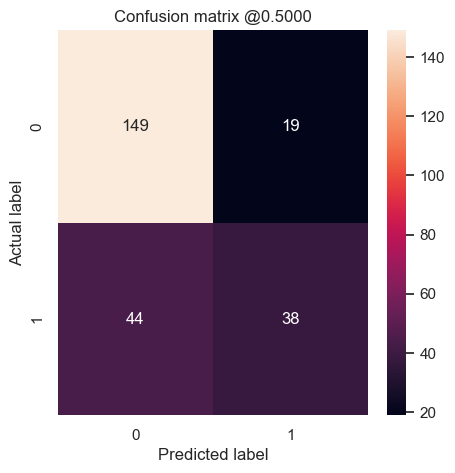

In [48]:
plot_cm(y_true, best_model.predict_proba(X_test)[:,1],p=0.5)

--------------------
The threshold is 0.36260121360072306
TN 130
FP 38
FN 32
TP 50
TOTAL CHURNS 82
--------------------


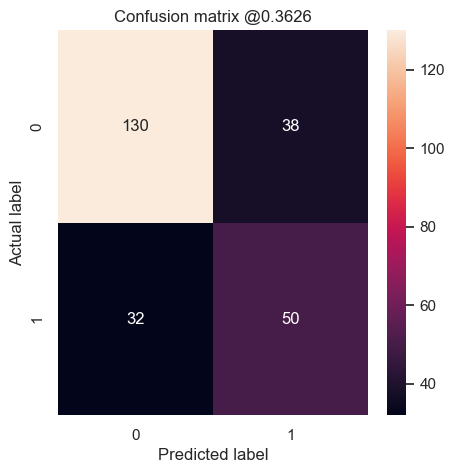

In [49]:
plot_cm(y_true, best_model.predict_proba(X_test)[:,1],p=best_thresh)

The final result is that we capture 50 out of the 82 churns, at the expense of having 38 false positives.